493, Anton Karazeev, anton.karazeev@phystech.edu

In [190]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1.1 Ответы в листьях регрессионного дерева

Что лучше - отвечать средним значением таргета на объектах обучающей выборки, попавших в лист, или отвечать таргетом для случайного объекта из листа (все объекты равновероятны)?

-- -- --

Обозначения: $y_i$ - истинные значения таргетов, $\hat y_i$ - предсказанные значения таргетов.

В первом случае: предсказанные таргеты - это среднее значение $\bar y$.

- Считаю мат. ож. MSE: $\mathbb E MSE(Y,\hat Y) = \frac{1}{n} \sum_i E (y_i - \hat y_i)^2 = \frac{1}{n} \sum_i Ey_i^2 + E\hat y_i^2 - 2y_i \bar y = \frac{1}{n} \sum_i y_i^2 + \left(\frac{\sum_j y_j}{n}\right)^2 - 2y_i \bar y$, в этом случае $y_i$ является фиксированным числом.

Во втором случае: предсказанные таргеты - случайная величина с равномерным распределением: $\hat y \sim Uniform$.

- Считаю мат. ож. MSE: $\mathbb E MSE(Y,\hat Y) = \frac{1}{n} \sum_i Ey_i^2 + E\hat y_i^2 - 2y_i \bar y = \frac{1}{n} \sum_i y_i^2 + \frac{\sum_j y_j^2}{n} - 2y_i \bar y$, т.к. $\mathbb E \hat y = \bar y.$

Получаю, что ошибка во втором случае больше, чем в первом, т.к. $\frac{\sum_j y_j^2}{n} \geqslant \left(\frac{\sum_j y_j}{n}\right)^2$ (поскольку выборочная дисперсия $\geqslant 0$).

Следовательно, лучше отвечать средним значением таргета на объектах обучающей выборки.

# 1.2 Линейные модели в деревьях

На лекции разбирался алгоритм построения дерева. "Качество" разбиения измерялось при помощи функции неоднородности:

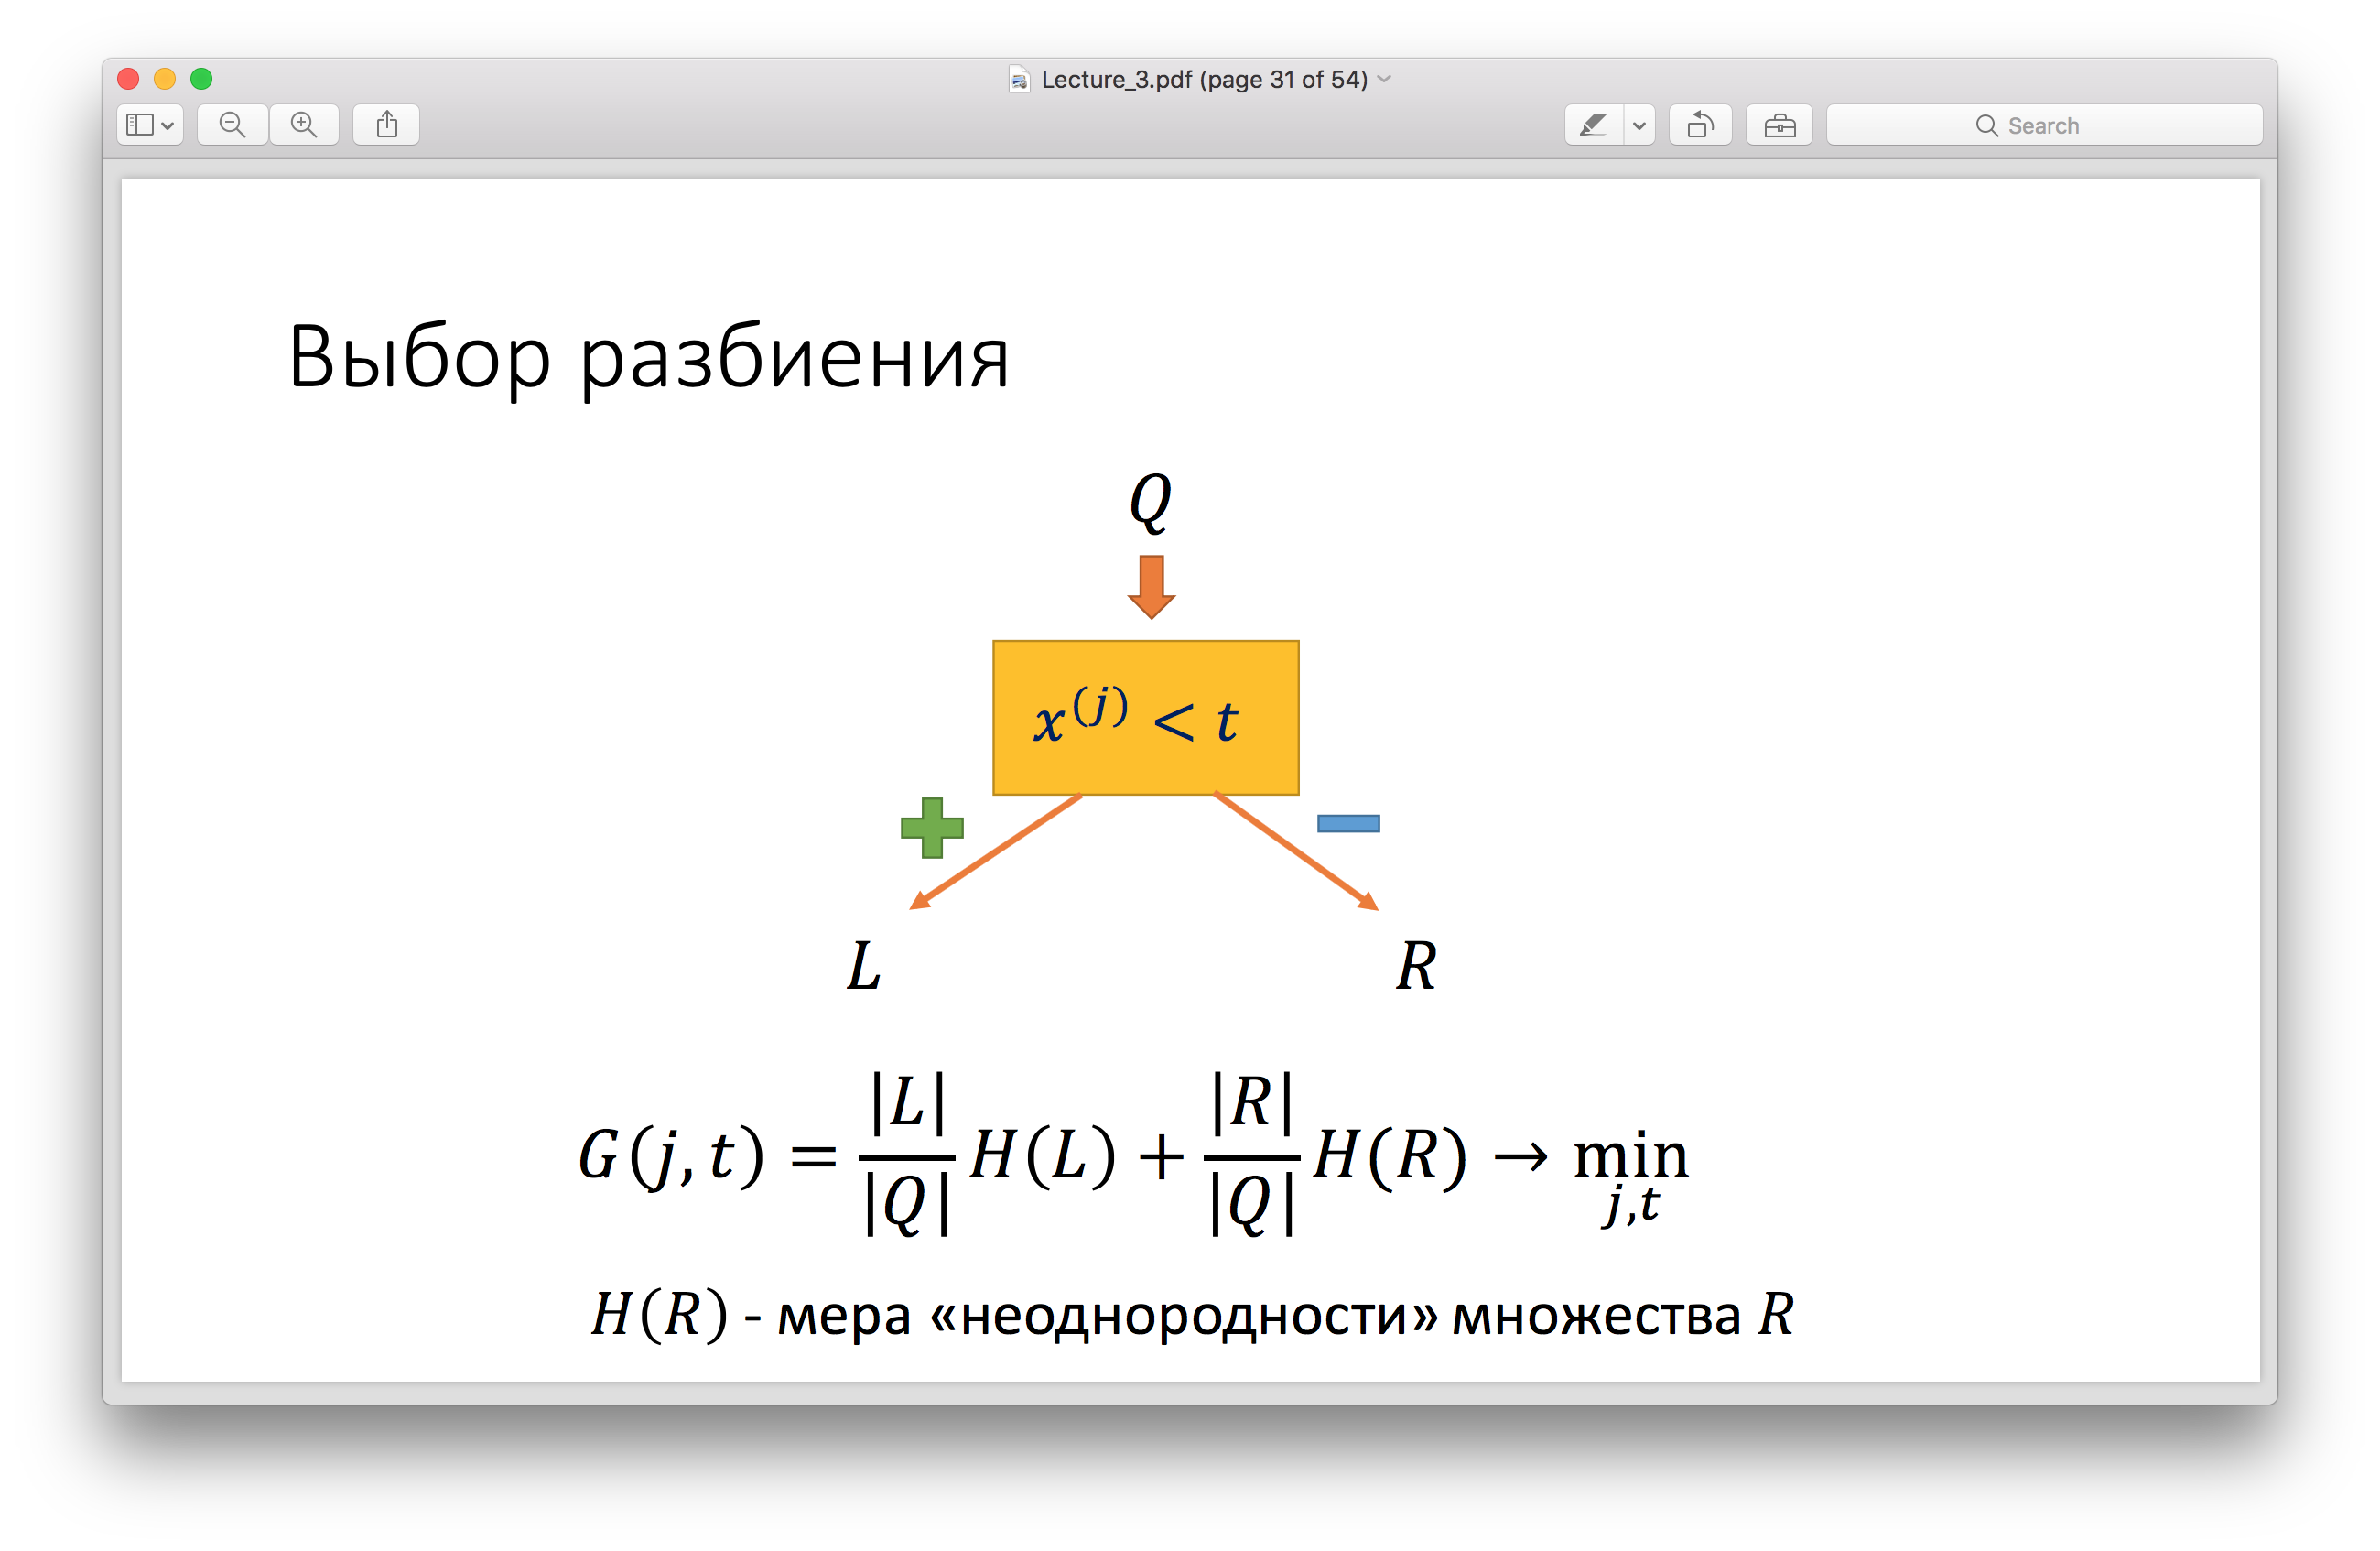

In [191]:
Image('fig1.png', width=600, height=600)

Линейная регрессия предполагает линейную зависимость данных. Вернее, она лучше всего подходит для данных, которые имеют линейную зависимость. В общем виде это не так. Поэтому "такая стратегия не даёт ощутимого выигрыша".

Модифицировать построение разбиений в дереве по MSE можно следующим образом:

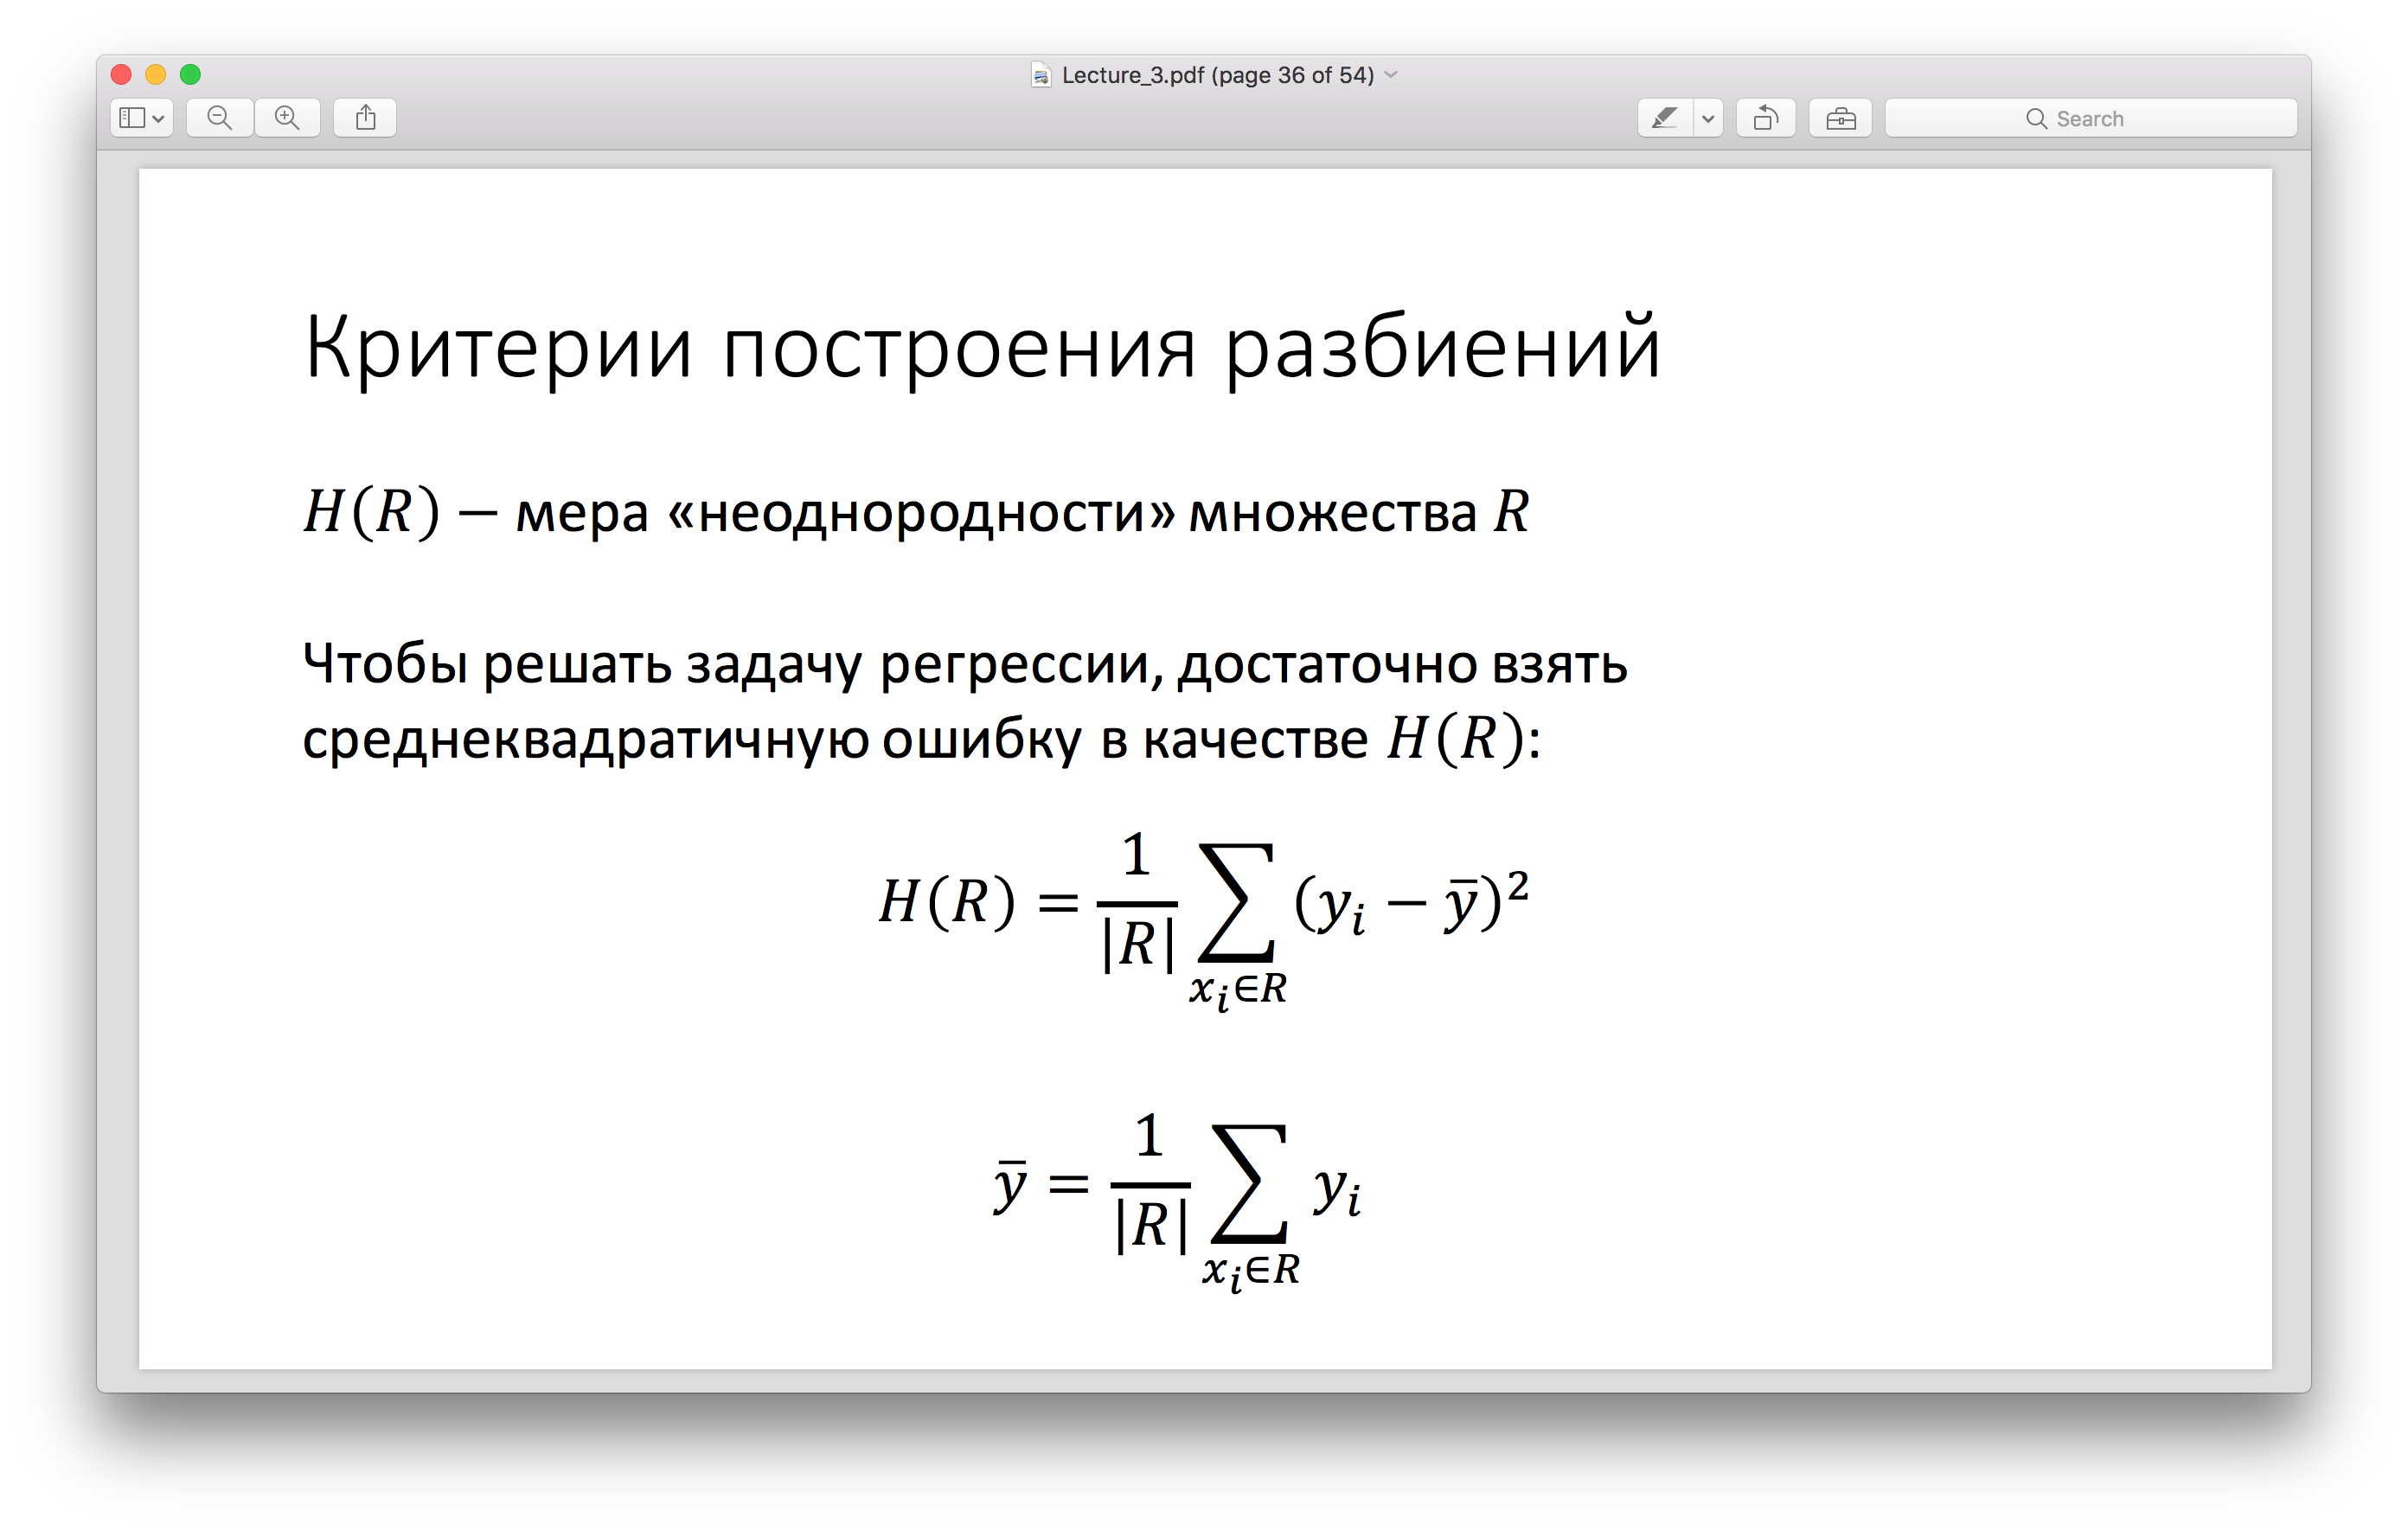

In [192]:
Image('fig2.png', width=600, height=600)

И подставить эту функцию H(R) в Q(j,t).

# 2 Применение решающего дерева

In [193]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import pydotplus

In [194]:
classes = {1 : 'good', 2 : 'bad'}

titles = []

with open('german.doc', 'r') as german_doc:
    flag = 0
    for line in german_doc.readlines():
        if 'Attribute' in line:
            flag = 1
        if flag == 2:
            titles.append(line.strip())
            flag = 0
        if flag == 1:
            flag = 2

titles.append('target')
titles = titles[2:]
print(len(titles))
titles

21


['Status of existing checking account',
 'Duration in month',
 'Credit history',
 'Purpose',
 'Credit amount',
 'Savings account/bonds',
 'Present employment since',
 'Installment rate in percentage of disposable income',
 'Personal status and sex',
 'Other debtors / guarantors',
 'Present residence since',
 'Property',
 'Age in years',
 'Other installment plans',
 'Housing',
 'Number of existing credits at this bank',
 'Job',
 'Number of people being liable to provide maintenance for',
 'Telephone',
 'foreign worker',
 'target']

In [195]:
data = pd.read_csv('german.data', ' ', header=None, names=titles)
data.head()

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [197]:
data_new = pd.DataFrame()

numerize_list = [0,2,3,5,6,8,9,11,13,14,16,18,19]

for i in range(len(titles)):
    if i in numerize_list:
        tmp = set(data[titles[i]].values)
        categ_dict = dict(zip(sorted(tmp),range(len(tmp))))
        data_new[titles[i]] = map(lambda x: categ_dict[x], data[titles[i]])
    else:
        data_new[titles[i]] = data[titles[i]]

In [198]:
data_new.head()

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker,target
0,0,6,4,4,1169,4,4,4,2,0,...,0,67,2,1,2,2,1,1,0,1
1,1,48,2,4,5951,0,2,2,1,0,...,0,22,2,1,1,2,1,0,0,2
2,3,12,4,7,2096,0,3,2,2,0,...,0,49,2,1,1,1,2,0,0,1
3,0,42,2,3,7882,0,3,2,2,2,...,1,45,2,2,1,2,2,0,0,1
4,0,24,3,0,4870,0,2,3,2,0,...,3,53,2,2,2,2,2,0,0,2


In [199]:
numerics = data_new[titles[:20]].as_matrix()
targets = data_new[titles[-1:]].values

c, r = targets.shape
targets = targets.reshape(c,)

Max at depth: 3


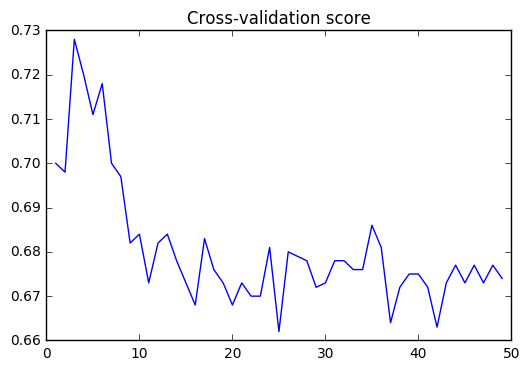

In [200]:
# Качество на кросс-валидации

scores = []
depths = range(1,50)

for depth in depths:
    mytree = DecisionTreeClassifier(max_depth=depth)
    scores.append(cross_val_score(mytree, numerics, targets, cv=10).mean())
    
print('Max at depth: {}'.format(np.argmax(scores)+1))
    
plt.figure()
plt.plot(depths, scores)
plt.title('Cross-validation score')
plt.show()

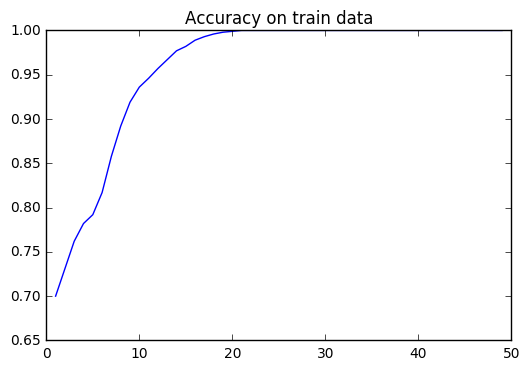

In [201]:
# Качество на обучающей выборке

scores = []

for depth in depths:
    mytree = DecisionTreeClassifier(max_depth=depth)
    mytree.fit(numerics, targets)
    scores.append(accuracy_score(mytree.predict(numerics), targets))
    
plt.figure()
plt.plot(depths, scores)
plt.title('Accuracy on train data')
plt.show()

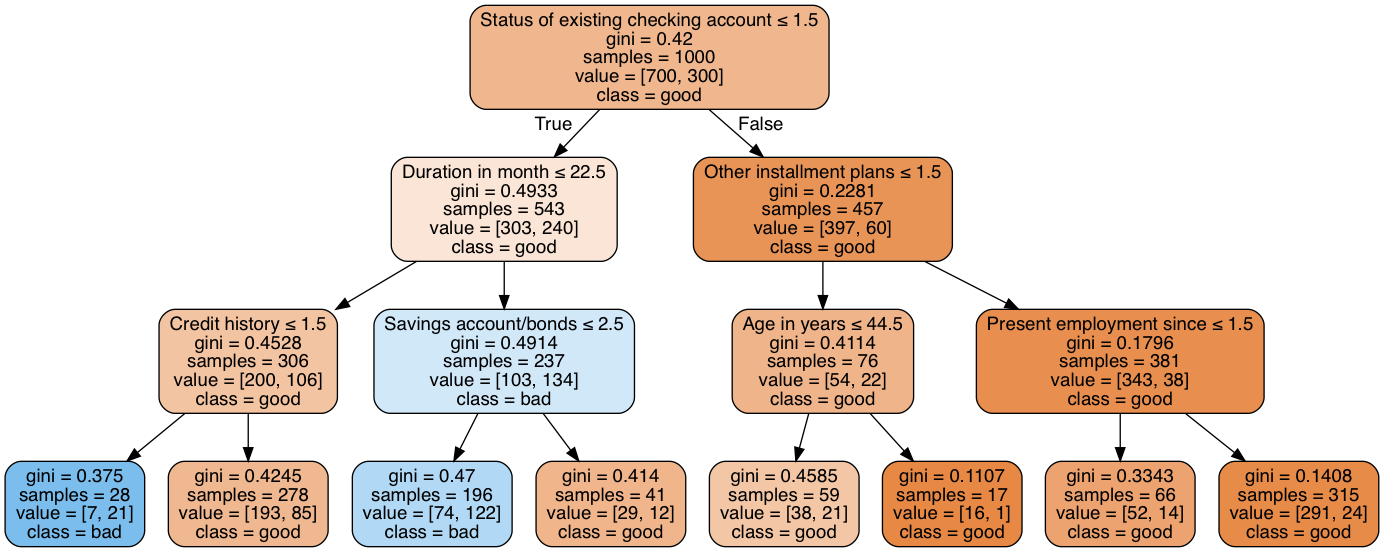

In [202]:
from IPython.display import Image

# Решающее дерево с максимальной глубиной 3

mytree = DecisionTreeClassifier(max_depth=3)
mytree.fit(numerics, targets)

dfile_name = "mytree.dot"
with open(dfile_name, 'w') as dotfile:
    tree.export_graphviz(mytree, out_file=dotfile, feature_names=titles, \
                         class_names=['good', 'bad'], filled=True, special_characters=True, \
                         rounded=True)
    
graph_from_file = pydotplus.graphviz.graph_from_dot_file(dfile_name)
graph_from_file.write_png('tree_3.png')
Image(graph_from_file.create_png())

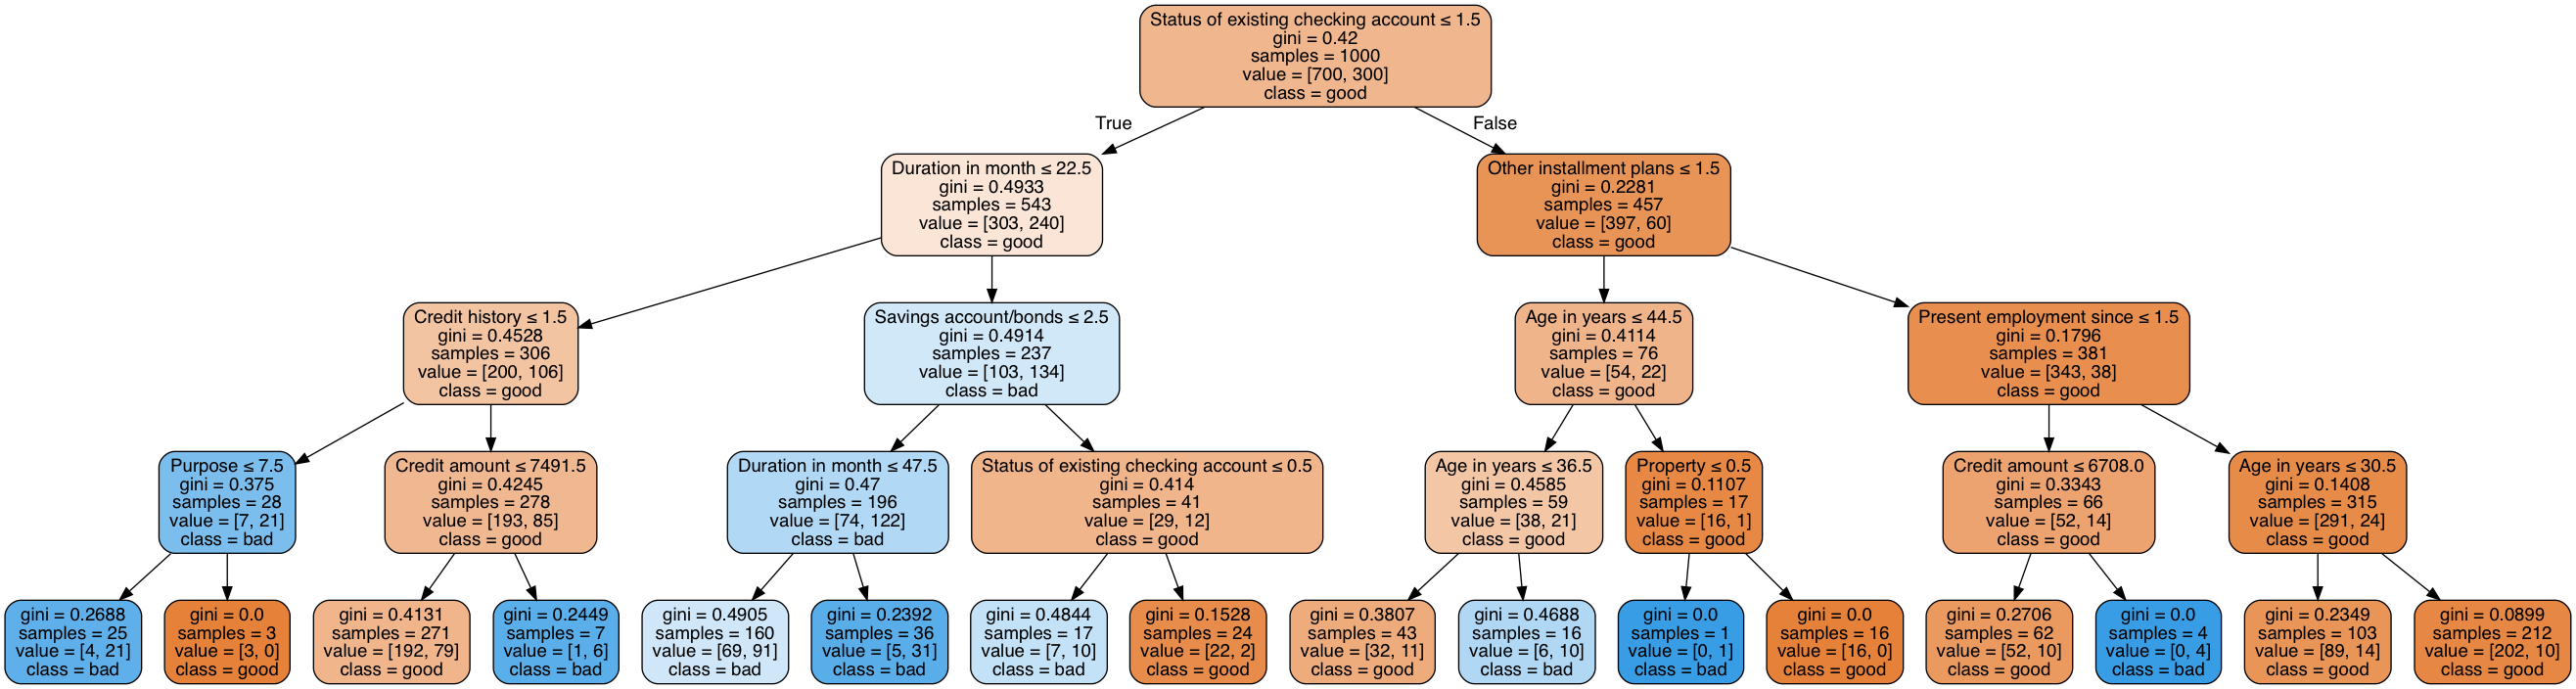

In [203]:
# Решающее дерево с максимальной глубиной 4

mytree = DecisionTreeClassifier(max_depth=4)
mytree.fit(numerics, targets)

dfile_name = "mytree.dot"
with open(dfile_name, 'w') as dotfile:
    tree.export_graphviz(mytree, out_file=dotfile, feature_names=titles, \
                         class_names=['good', 'bad'], filled=True, special_characters=True, \
                         rounded=True)
    
graph_from_file = pydotplus.graphviz.graph_from_dot_file(dfile_name)
graph_from_file.write_png('tree_4.png')
Image(graph_from_file.create_png())